# Recipe Site Traffic Prediction


Predict the popular recipes to be show on the homepage.
**Objectives**:
- Predict which recipes will lead to high traffic?
- Correctly predict high traffic recipes 80% of the time?

**Import libraries and dataset**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv('recipe_site_traffic_2212.csv')
df.head()

,recipe,calories,carbohydrate,sugar,protein,category,servings,high_traffic
0,1,NaN,NaN,NaN,NaN,Pork,6,High
1,2,35.48,38.56,0.66,0.92,Potato,4,High
2,3,914.28,42.68,3.09,2.88,Breakfast,1,NaN
3,4,97.03,30.56,38.63,0.02,Beverages,4,High
4,5,27.05,1.85,0.80,0.53,Beverages,4,NaN


In [3]:
df.shape

(947, 8)

## 1. Data Validation

The dataset has 947 rows and 8 columns. After validating data I have made some changes.
- recipe : 947 unique values without missing values, same as description no need to cleaned.
- calories : 895 non-null values, same as description. Missing values filled by the median value of calories.
- carbohydrate : 895 non-null values, same as description. Missing values filled by the median value of carbohydrate.
- sugar : 895 non-null values, same as description. Missing values filled by the median value of sugar.
- protein : 895 non-null values, same as description. Missing values filled by the median value of protein.
- category : 11 unique values without missing values, not same as description. As the 'Chicken Breast' was additional value from the description, replaced 'Chicken Breast' to 'Chicken'.
- servings : 6 unique values without missing values. Additional values as '4 as a snack' and '6 as a snack' replaced to '4' and '6'.
- high_traffic : 1 unique values with 373 missing values, same as description. The missing values filled by 'Low'.

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 947 entries, 0 to 946
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   recipe        947 non-null    int64  
 1   calories      895 non-null    float64
 2   carbohydrate  895 non-null    float64
 3   sugar         895 non-null    float64
 4   protein       895 non-null    float64
 5   category      947 non-null    object 
 6   servings      947 non-null    object 
 7   high_traffic  574 non-null    object 
dtypes: float64(4), int64(1), object(3)
memory usage: 59.3+ KB


## Checking missing values

In [5]:
df.isna().sum()

recipe            0
calories         52
carbohydrate     52
sugar            52
protein          52
category          0
servings          0
high_traffic    373
dtype: int64

**High Traffic**

In [6]:
df['high_traffic'].value_counts()

High    574
Name: high_traffic, dtype: int64

As the high_traffic column has only 1 unique value that is 'High'. I replaced the missing values in this column with 'Low'

In [7]:
df['high_traffic'] = df['high_traffic'].fillna('Low')
df['high_traffic'] = df['high_traffic'].astype('category')
df['high_traffic'].value_counts()

High    574
Low     373
Name: high_traffic, dtype: int64

Fill the missing values of 'calories', 'carbohydrate', 'sugar', and 'protein' columns with median value of each column.

In [8]:
df['calories'].fillna(df['calories'].median(), inplace=True)
df['carbohydrate'].fillna(df['carbohydrate'].median(), inplace=True)
df['sugar'].fillna(df['sugar'].median(), inplace=True)
df['protein'].fillna(df['protein'].median(), inplace=True)

**Category**

In [9]:
df['category'].value_counts()

Breakfast         106
Chicken Breast     98
Beverages          92
Lunch/Snacks       89
Potato             88
Pork               84
Vegetable          83
Dessert            83
Meat               79
Chicken            74
One Dish Meal      71
Name: category, dtype: int64

Replace the 'Chicken Breast' to 'Chicken' in 'category' column

In [10]:
df['category'] = df['category'].replace({"Chicken Breast": 'Chicken'})
df['category'].value_counts()

Chicken          172
Breakfast        106
Beverages         92
Lunch/Snacks      89
Potato            88
Pork              84
Vegetable         83
Dessert           83
Meat              79
One Dish Meal     71
Name: category, dtype: int64

**Servings**

In [11]:
df['servings'].value_counts()

4               389
6               197
2               183
1               175
4 as a snack      2
6 as a snack      1
Name: servings, dtype: int64

Replacing string from 'servings' column

In [12]:
df['servings'] = df['servings'].str.replace(' as a snack','')
df['servings'] = df['servings'].astype('int')
df['servings'].value_counts()

4    391
6    198
2    183
1    175
Name: servings, dtype: int64

---

## 2. Exploratory Data Analysis

**Count of High Traffic**

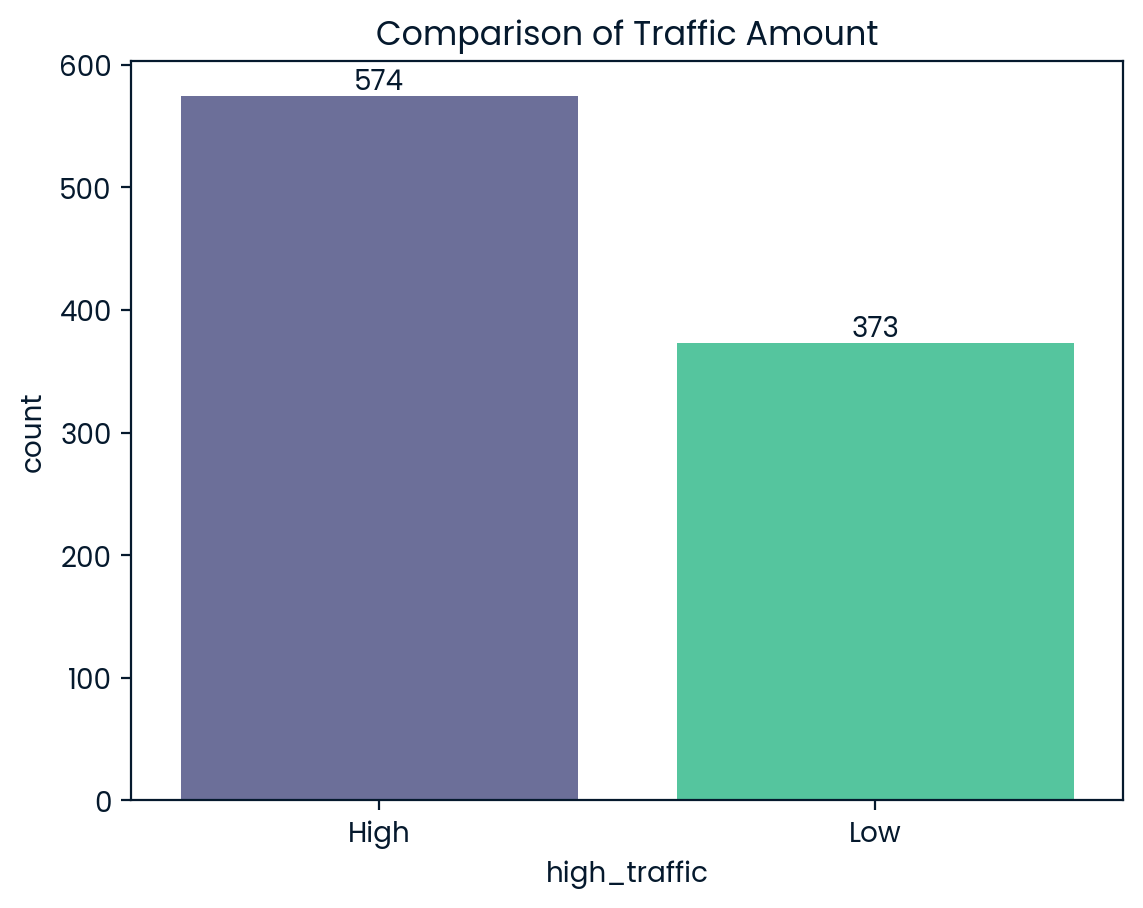

In [13]:
ax = sns.countplot(x='high_traffic', hue='high_traffic', data=df)
plt.title('Comparison of Traffic Amount')
for label in ax.containers:
    ax.bar_label(label)
plt.show()

- It shows that High traffic recipes are higher than Low traffic recipes with 574 to 373.

**Traffic Amount with categories**

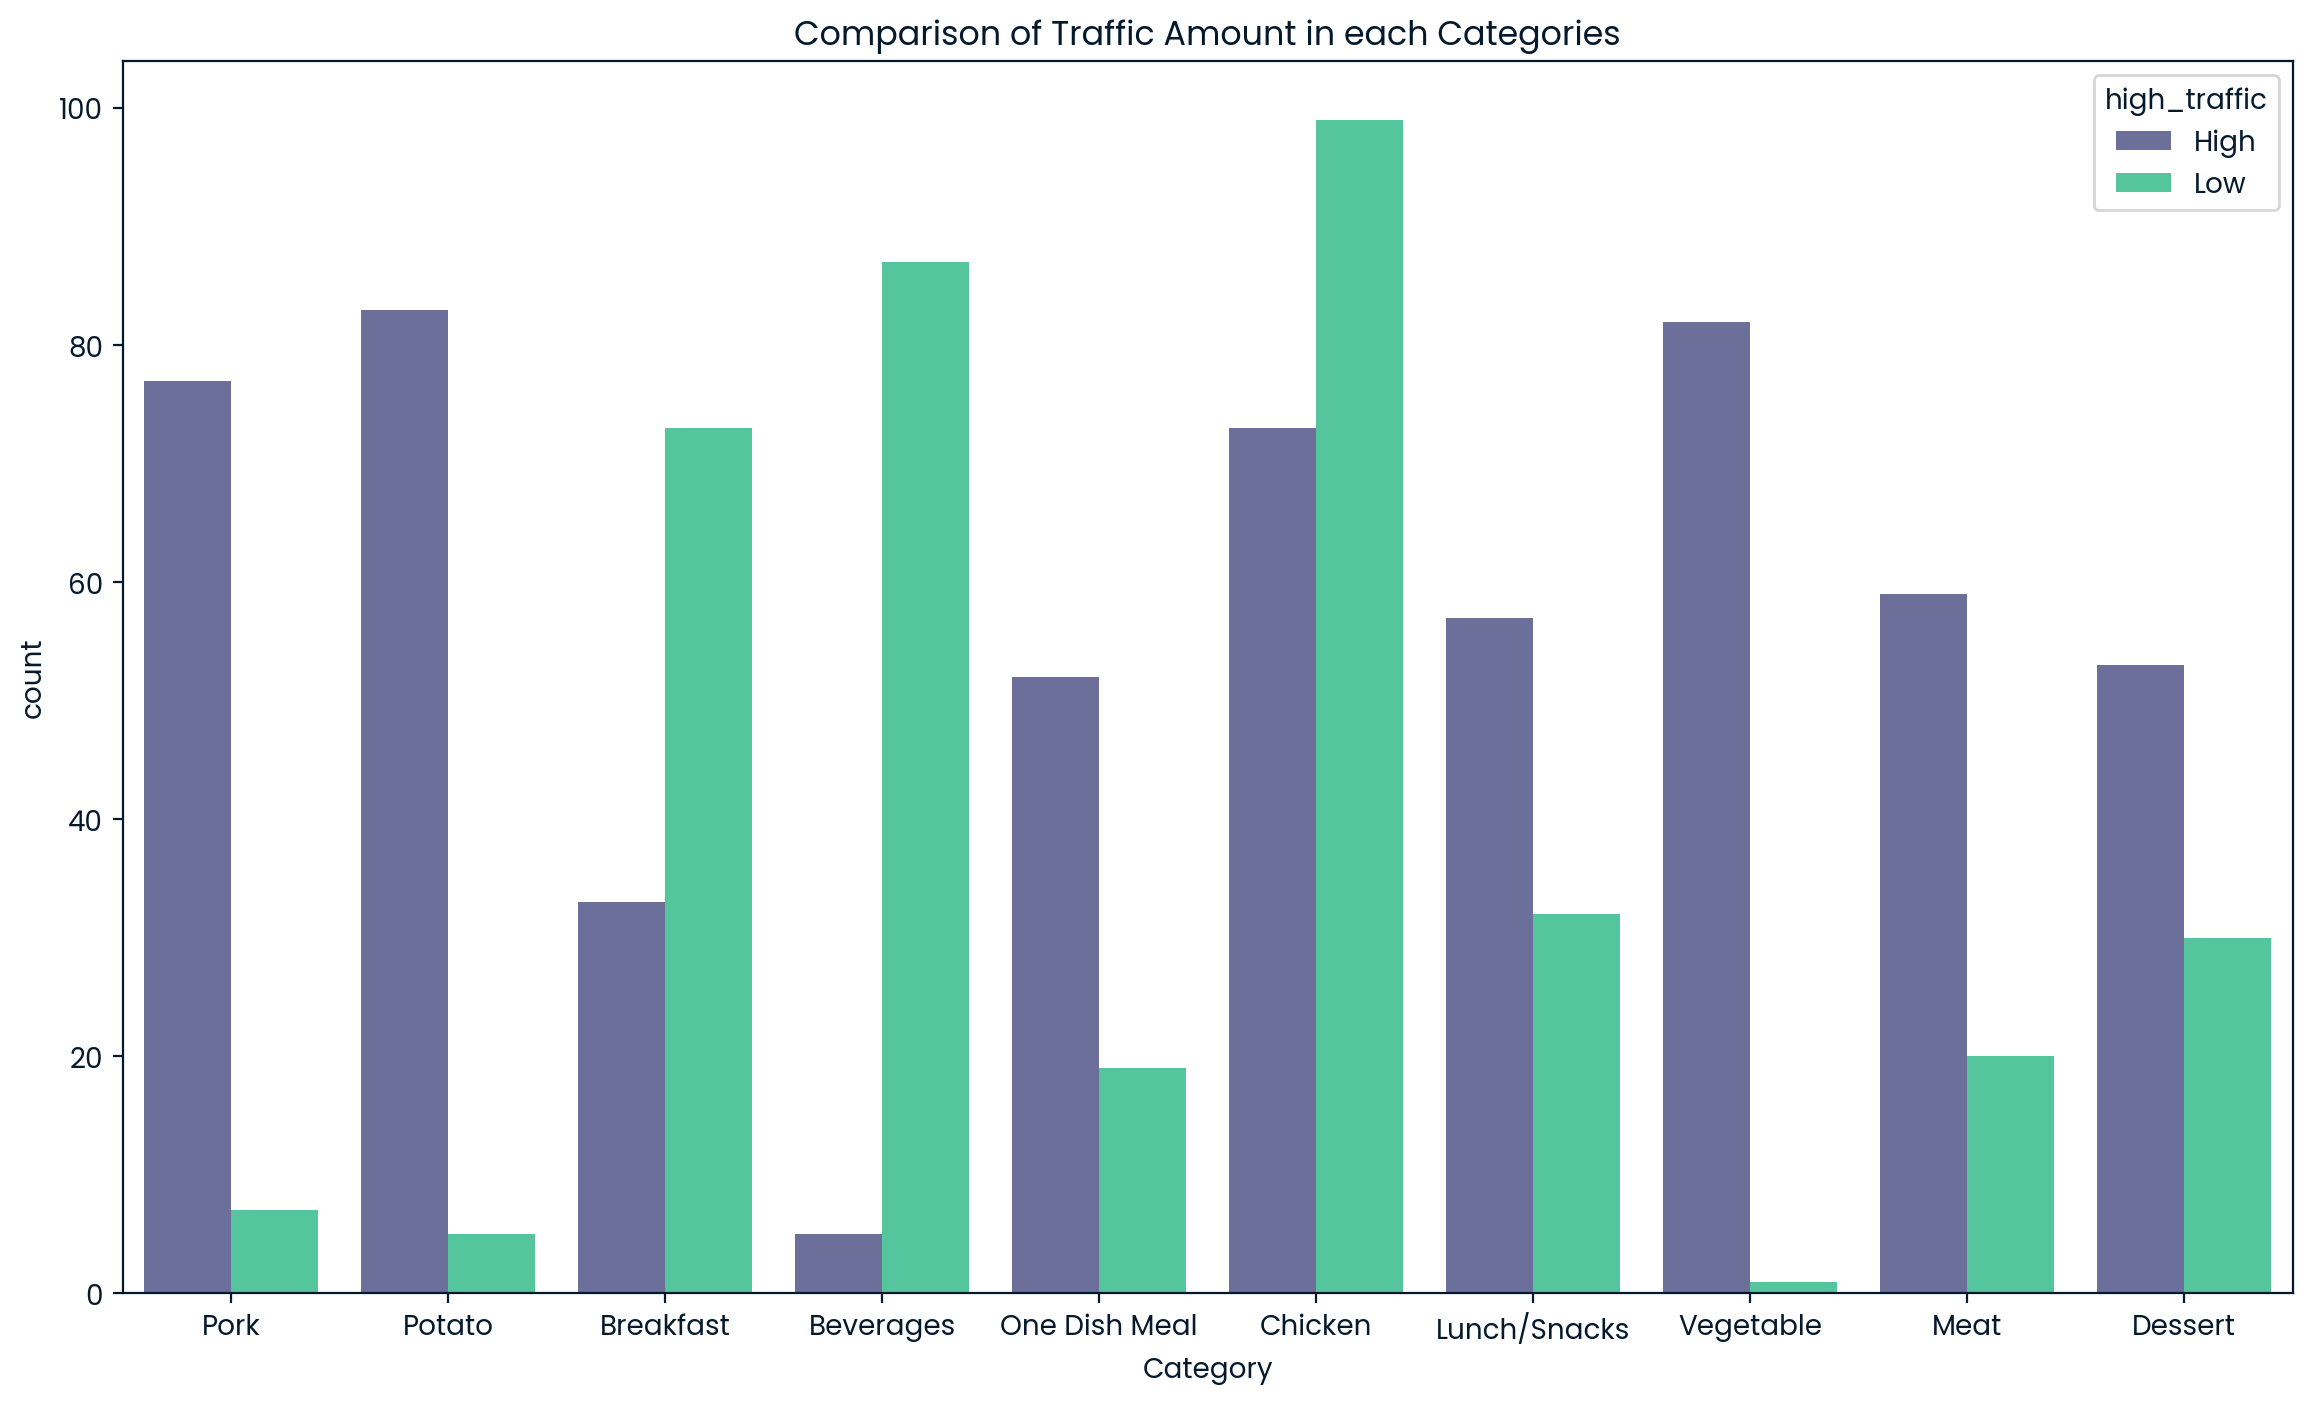

In [14]:
plt.figure(figsize=(14, 8))
sns.countplot(data=df, x='category', hue="high_traffic")
plt.title('Comparison of Traffic Amount in each Categories')
plt.xlabel('Category')
plt.show()

- Potato, Vegetable, and Pork category are the 3 highest amount of high traffic category count than other.
- Breakfast, Beverages, and Chicken are the categories that have amount of low traffic higher than high traffic.

**Serving size per Traffic**

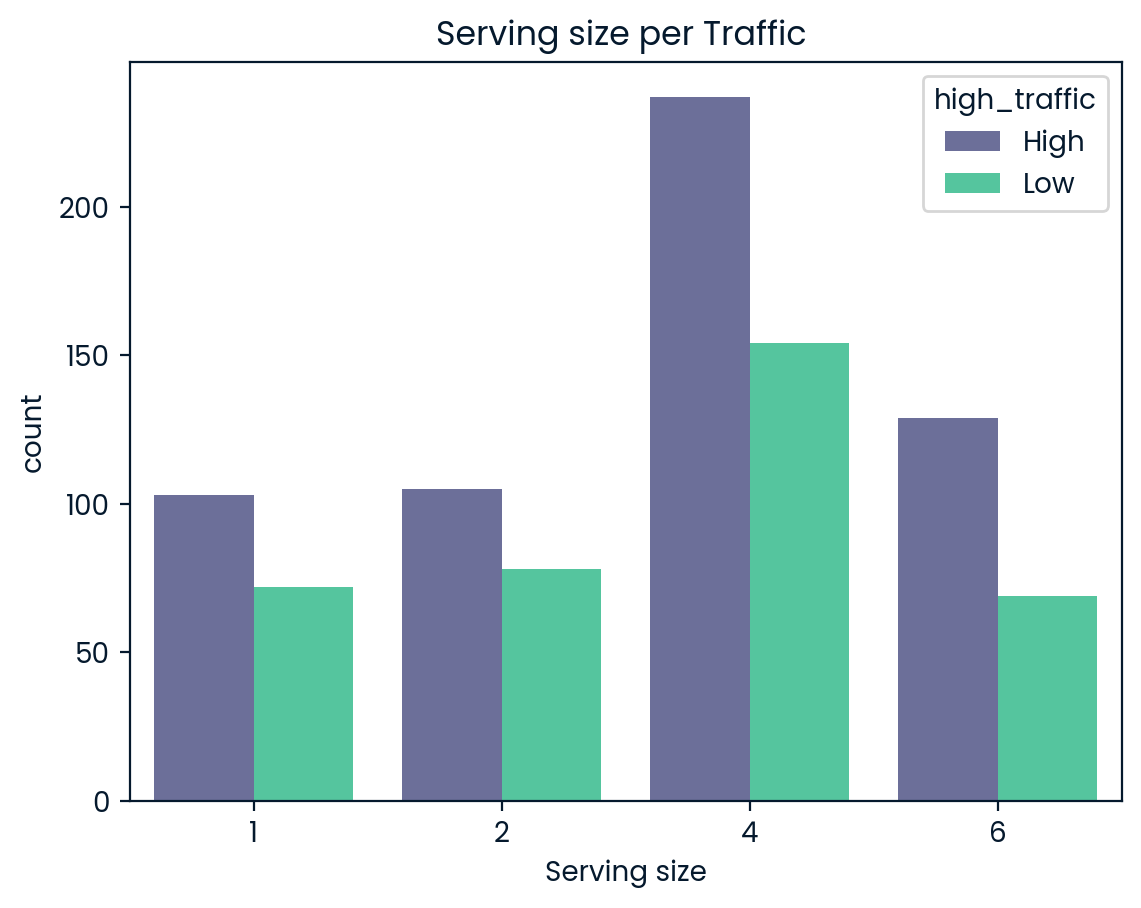

In [15]:
sns.countplot(data=df, x='servings',hue='high_traffic', 
              order=df.servings.value_counts().sort_index().index)
plt.title('Serving size per Traffic ')
plt.xlabel('Serving size')
plt.show()

- Every serving size have the amount of high traffic more than low traffic.

---

## 3. Model Development

- Predicting the 'high_traffic' column using Logistic Regression and Random Forest Model for solving a binary classification problem.
    - Logistic Regression is a supervised machine learning algorithm used for classification tasks in which the goal is to predict whether an instance belongs to a specific class or not. 
    - Random forests are a popular supervised machine learning technique that can handle both regression and classification tasks. Random forests are an ensemble method, which means they use predictions from multiple models.

**Import libraries for model development**

In [16]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn import metrics
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

**Applying label encoding to category column**

In [17]:
label_encoder = LabelEncoder()
df['category']= label_encoder.fit_transform(df['category'])

**Split Data into features and target**

In [18]:
X = df.drop(columns = ['recipe', 'high_traffic'])
y = df['high_traffic']

**Split Training and Test Data**

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y,test_size=0.2, random_state=101)

X_train.shape,y_train.shape, X_test.shape, y_test.shape

((757, 6), (757,), (190, 6), (190,))

## 4. Model Evaluation

I will use GridSearchCV to find the best parameter that gives highest accuracy score of that model.

In [20]:
lr = LogisticRegression(random_state=42)
param_grid = {
    'penalty': ['l1', 'l2', 'elasticnet', 'none'],
    'C': [0.01, 0.1, 1, 10, 100],
    'solver': ['lbfgs', 'liblinear', 'saga']  
}

# Setup GridSearchCV
grid_search_lr = GridSearchCV(estimator=lr, param_grid=param_grid, cv=5, scoring='accuracy')

# Fit the grid search model
grid_search_lr.fit(X_train, y_train)

print(grid_search_lr.best_params_)

{'C': 0.1, 'penalty': 'l1', 'solver': 'liblinear'}


In [21]:
best_lr = LogisticRegression(random_state=42, C=0.1, penalty='l2', solver='liblinear')
best_lr.fit(X_train, y_train)

# Predict on the test set
y_pred_best_lr = best_lr.predict(X_test)
report = classification_report(y_test, y_pred_best_lr)
print("Classification Report: Logistic Regression\n", report)

Classification Report: Logistic Regression
               precision    recall  f1-score   support

        High       0.81      0.80      0.80       115
         Low       0.70      0.71      0.70        75

    accuracy                           0.76       190
   macro avg       0.75      0.75      0.75       190
weighted avg       0.76      0.76      0.76       190



The accuracy score is 0.76, precision score is 0.75, recall score is 0.75, and f1 score is 0.75.

In [22]:
rf = RandomForestClassifier(random_state=42)
param_grid = { 
    'n_estimators':[10, 100, 250, 500],
    'criterion':['gini', 'entropy'],
    'max_depth':[1, 5, 10, 25],
    'min_samples_leaf':[1, 5, 10],
    'min_samples_split':[2, 5, 10],
}

# Setup GridSearchCV
grid_search_rf = GridSearchCV(estimator=rf, param_grid=param_grid, cv=3, scoring='accuracy', n_jobs = -1)

# Fit the grid search model
grid_search_rf.fit(X_train, y_train)

print(grid_search_rf.best_params_)

{'criterion': 'entropy', 'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 100}


In [23]:
best_rf = RandomForestClassifier(n_estimators=100, random_state=42, criterion='entropy', max_depth=5, min_samples_leaf=1, min_samples_split=5)
best_rf.fit(X_train, y_train)

# Predict on the test set
y_pred_best_rf = best_rf.predict(X_test)
report = classification_report(y_test, y_pred_best_rf)
print("Classification Report: Random Forest\n", report)

Classification Report: Random Forest
               precision    recall  f1-score   support

        High       0.81      0.83      0.82       115
         Low       0.74      0.71      0.72        75

    accuracy                           0.78       190
   macro avg       0.77      0.77      0.77       190
weighted avg       0.78      0.78      0.78       190



The accuracy score is 0.78, precision score is 0.77, recall score is 0.76, and f1 score is 0.77.

---

## 5. Business Metrics

Compare the accuracy score of Logistic Regression model and Random Forest model.

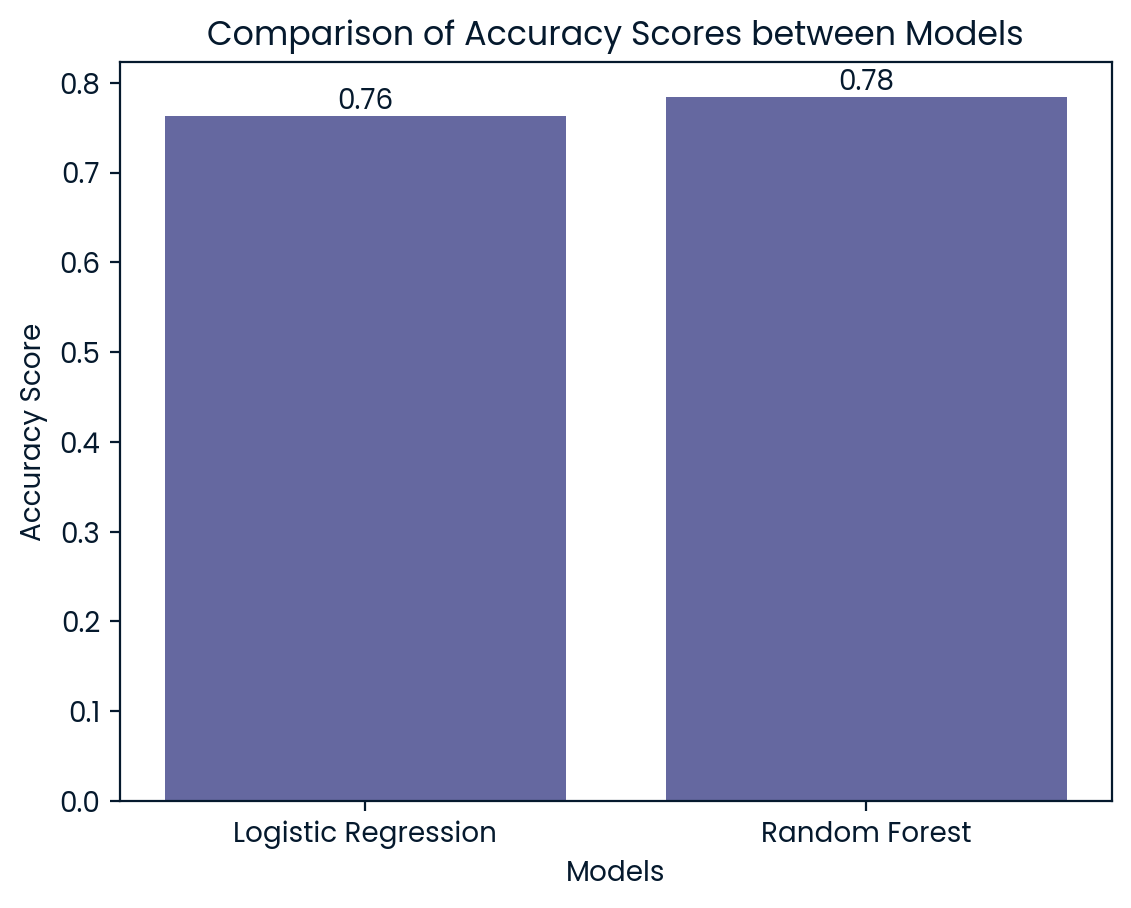

In [24]:
test_accuracy_lr = accuracy_score(y_test, y_pred_best_lr)
test_accuracy_rf = accuracy_score(y_test, y_pred_best_rf)

models = ['Logistic Regression', 'Random Forest']
accuracy_scores = [test_accuracy_lr, test_accuracy_rf]

plt.bar(models, accuracy_scores)
plt.xlabel('Models')
plt.ylabel('Accuracy Score')

# Add value labels to the bars
for i, v in enumerate(accuracy_scores):
    plt.text(i, v, str(round(v, 2)), ha='center', va='bottom')

plt.title('Comparison of Accuracy Scores between Models')
plt.show()

- Random Forest has higher accuracy score (0.78) than Logistic Regression (0.76).

---

## Recommendations

- Deploying the Random Forest model as this model has better accuracy, precision, recall, and f1 score than the Logistic Regression model. Also with the precision, recall, and f1 score predicting the high traffic.
- Increasing the website traffic by displaying recipe categories like Vegetable, Potato, and Pork, which are the top 3 high amounts of traffic.
- Collect more data like views to see how many times each recipe was viewed, ingredients of each recipe to attract users to be interested in which ingredients are used for each recipe, and the cost of recipes to improve the model performance.